In [2]:
import mmcv
import mmengine
from mmdet.apis import init_detector, inference_detector
from mmdet.utils import register_all_modules
# Choose to use a config and initialize the detector
config_file = '../configs/mask_rcnn/mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco.py'
# Setup a checkpoint file to load
checkpoint_file = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# register all modules in mmdet into the registries
register_all_modules()

# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')  # or device='cuda:0'


Loads checkpoint by local backend from path: checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth


From the printed model, we will find that the model does consist of the components that we described earlier. It uses ResNet as its CNN backbone, and has a RPN head and RoI Head.
The RoI Head includes box head and mask head. In addition, the model has a neural network module, named neck, directly after the CNN backbone. It is a [feature pyramid network (FPN)](https://arxiv.org/abs/1612.03144) for enhancing the multi-scale features.


### Inference with the detector

The model is successfully created and loaded, let's see how good it is. We use the high-level API `inference_detector` implemented in the MMDetection. This API is created to ease the inference process. The details of the codes can be found [here](https://github.com/open-mmlab/mmdetection/blob/master/mmdet/apis/inference.py#L15).

In [3]:
# Use the detector to do inference
image = mmcv.imread('../demo/demo.jpg',channel_order='rgb')
result = inference_detector(model, image)
print(result)

<DetDataSample(

    META INFORMATION
    ori_shape: (427, 640)
    batch_input_shape: (800, 1216)
    img_path: None
    scale_factor: (1.8734375, 1.873536299765808)
    img_id: 0
    img_shape: (800, 1199)
    pad_shape: (800, 1216)

    DATA FIELDS
    gt_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            bboxes: tensor([], device='cuda:0', size=(0, 4))
            masks: BitmapMasks(num_masks=0, height=427, width=640)
            labels: tensor([], device='cuda:0', dtype=torch.int64)
        ) at 0x2aa8e8177f0>
    ignored_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            bboxes: tensor([], device='cuda:0', size=(0, 4))
            masks: BitmapMasks(num_masks=0, height=427, width=640)
            labels: tensor([], device='cuda:0', dtype=torch.int64)
        ) at 0x2aa8e8178b0>
    pred_instances: <InstanceData(
        
            META INFORMATION
        
       

### Let's plot the result

In [4]:
from mmdet.registry import VISUALIZERS
# init visualizer(run the block only once in jupyter notebook)
visualizer = VISUALIZERS.build(model.cfg.visualizer)
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_detector
visualizer.dataset_meta = model.dataset_meta

c:\Soft\miniconda3\envs\pytorch\lib\site-packages\mmengine\visualization\visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


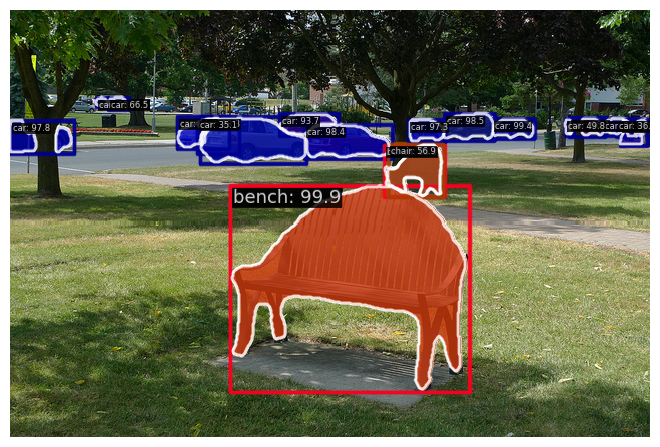

In [5]:
# show the results
visualizer.add_datasample(
    'result',
    image,
    data_sample=result,
    draw_gt = None,
    wait_time=0,
)
visualizer.show()

## Train a Detector on A Customized Dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector



### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [1]:
from mmengine import Config
cfg = Config.fromfile('../configs/mask_rcnn/mask-rcnn_r50-caffe_fpn_ms-poly-1x_coco.py')

Given a config that trains a Mask R-CNN on COCO dataset, we need to modify some values to use it for training on the balloon dataset.

In [ ]:
from mmengine.runner import set_random_seed

# Modify dataset classes and color
cfg.metainfo = {
    'classes': ('kengtang','fufa','wangxiang' ),
    'palette': [
        (220, 20, 60),
        (192, 0, 128), 
        (192, 128, 128)
    ]
}

# Modify dataset type and path
cfg.data_root = './datasets/fishery'

cfg.train_dataloader.dataset.ann_file = 'annotations/train.json'
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix.img = 'train/'
cfg.train_dataloader.dataset.metainfo = cfg.metainfo

cfg.val_dataloader.dataset.ann_file = 'annotations/val.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = 'val/'
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

cfg.test_dataloader = cfg.val_dataloader

# Modify metric config
cfg.val_evaluator.ann_file = cfg.data_root+'/'+'annotations/val.json'
cfg.test_evaluator = cfg.val_evaluator

# Modify num classes of the model in box head and mask head
cfg.model.roi_head.bbox_head.num_classes = 1
cfg.model.roi_head.mask_head.num_classes = 1

# We can still the pre-trained Mask RCNN model to obtain a higher performance
cfg.load_from = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'


# We can set the evaluation interval to reduce the evaluation times
cfg.train_cfg.val_interval = 3
# We can set the checkpoint saving interval to reduce the storage cost
cfg.default_hooks.checkpoint.interval = 3

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optim_wrapper.optimizer.lr = 0.02 / 8
cfg.default_hooks.logger.interval = 10


# Set seed thus the results are more reproducible
# cfg.seed = 0
set_random_seed(0, deterministic=False)

# We can also use tensorboard to log the training process
# cfg.visualizer.vis_backends.append({"type":'TensorboardVisBackend'})

#------------------------------------------------------
config=f'../configs/mask_rcnn/mask-rcnn_r50-caffe_fpn_ms-poly-3x_fishery.py'
with open(config, 'w',encoding='utf-8') as f:
    f.write(cfg.pretty_text)

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [20]:
# !python ../tools/train.py {config}
!python ../tools/train.py ../configs/mask_rcnn/mask-rcnn_r50-caffe_fpn_ms-poly-3x_fishery.py

11/27 18:55:27 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: win32
    Python: 3.8.19 (default, Mar 20 2024, 19:55:45) [MSC v.1916 64 bit (AMD64)]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1076585503
    GPU 0: NVIDIA T600 Laptop GPU
    CUDA_HOME: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.1
    NVCC: Cuda compilation tools, release 12.1, V12.1.105
    MSVC: 用于 x64 的 Microsoft (R) C/C++ 优化编译器 19.39.33523 版
    GCC: n/a
    PyTorch: 2.3.0+cu118
    PyTorch compiling details: PyTorch built with:
  - C++ Version: 201703
  - MSVC 192930151
  - Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.3.6 (Git Hash 86e6af5974177e513fd3fee58425e1063e7f1361)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture 

C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cuda\Loss.cu:186: block: [0,0,0], thread: [0,0,0] Assertion `cur_target >= 0 && cur_target < n_classes` failed.
C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cuda\Loss.cu:186: block: [0,0,0], thread: [1,0,0] Assertion `cur_target >= 0 && cur_target < n_classes` failed.
C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cuda\Loss.cu:186: block: [0,0,0], thread: [2,0,0] Assertion `cur_target >= 0 && cur_target < n_classes` failed.
C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cuda\Loss.cu:186: block: [0,0,0], thread: [3,0,0] Assertion `cur_target >= 0 && cur_target < n_classes` failed.
C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cuda\Loss.cu:186: block: [0,0,0], thread: [4,0,0] Assertion `cur_target >= 0 && cur_target < n_classes` failed.
C:\actions-runn

### Understand the log
From the log, we can have a basic understanding on the training process and know how well the detector is trained.

First, since the dataset we are using is small, we loaded a Mask R-CNN model and finetune it for detection. Because the original Mask R-CNN is trained on COCO dataset that contains 80 classes but KITTI Tiny dataset only have 3 classes. Therefore, the last FC layers of the pre-trained Mask R-CNN for classification and regression have different weight shape and are not used. The pre-trained weights of mask prediction layer `mask_head.conv_logits` also does not matches the current model and is not used due to similar reason.

Third, after training, the detector is evaluated by the default COCO-style evaluation. The results show that the detector achieves 79.6 bbox AP and 81.5 mask AP on the val dataset, not bad!

 We can also check the tensorboard to see the curves.

In [ ]:
%pip install tensorboard  -i https://mirrors.ustc.edu.cn/pypi/web/simple

In [21]:
# load tensorboard in jupyter notebook
%load_ext tensorboard

In [ ]:
# see curves in tensorboard
# if you see <IPython.core.display.HTML object> please run it again
%tensorboard --logdir tutorial_exps/

## Test the Trained Detector

After finetuning the detector, let's visualize the prediction results!

In [15]:
import mmcv
from mmdet.apis import init_detector, inference_detector
img = mmcv.imread('./ballondatasets/balloon/train/7178882742_f090f3ce56_k.jpg',channel_order='rgb')
checkpoint_file = 'tutorial_exps/epoch_12.pth'
model = init_detector(cfg, checkpoint_file, device='cpu')
new_result = inference_detector(model, img)
print(new_result)

Loads checkpoint by local backend from path: tutorial_exps/epoch_12.pth


FileNotFoundError: tutorial_exps/epoch_12.pth can not be found.

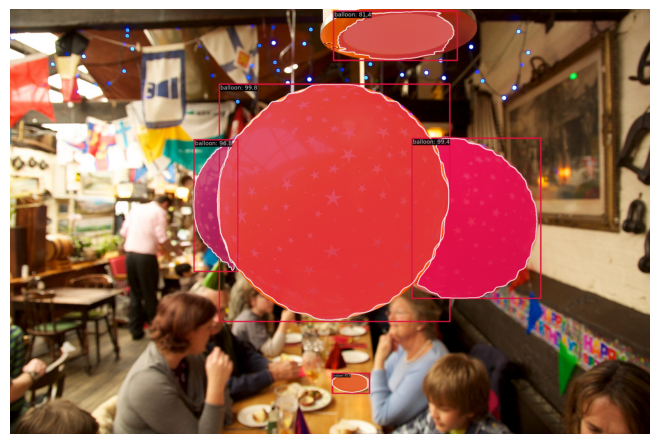

In [24]:
from mmengine.visualization import Visualizer
# get built visualizer
visualizer_now = Visualizer.get_current_instance()
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_detector
visualizer_now.dataset_meta = model.dataset_meta
# show the results
visualizer_now.add_datasample(
    'new_result',
    img,
    data_sample=new_result,
    draw_gt=False,
    wait_time=0,
    out_file=None,
    pred_score_thr=0.5
)
visualizer_now.show()

## What to Do Next?

So far, we have learnt how to test and train Mask R-CNN. To further explore the segmentation task, you could do several other things as shown below:

- Try cascade methods, e.g., [Cascade Mask R-CNN](https://github.com/open-mmlab/mmdetection/tree/master/configs/cascade_rcnn) and [HTC](https://github.com/open-mmlab/mmdetection/tree/master/configs/htc) in [MMDetection model zoo](https://github.com/open-mmlab/mmdetection/blob/master/docs/en/model_zoo.md). They are powerful detectors that are ranked high in many benchmarks, e.g., COCO dataset.
- Try single-stage methods, e.g., [K-Net](https://github.com/ZwwWayne/K-Net) and [Dense-RepPoints](https://github.com/justimyhxu/Dense-RepPoints). These two algorithms are based on MMDetection. Box-free instance segmentation is a new trend in the instance segmentation community.
- Try semantic segmentation. Semantic segmentation is also a popular task with wide applications. You can explore [MMSegmentation](https://github.com/open-mmlab/mmsegmentation/); we also provide a [colab tutorial](https://github.com/open-mmlab/mmsegmentation/blob/master/demo/MMSegmentation_Tutorial.ipynb) for semantic segmentation using MMSegmentation.
